Sheet 4.2: Non-linear regression (MLP w/ PyTorch modules)
=========================================================

**Author:** Michael Franke



In this tutorial, we will fit a non-linear regression, implemented as a multi-layer perceptron.
We will see how the use of modules from PyTorch&rsquo;s neural network package \`torch.nn\` helps us implement the model efficiently.



## Packages & global parameters



We will need to import the \`torch\` package for the main functionality.
In order to have a convenient handle, we load the \`torch.nn.functional\` package into variable \`F\`.
On top of that, we will use PyTorch&rsquo;s \`DataLoader\` and \`Dataset\` in order to feed our training data to the model.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## True model & training data



The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



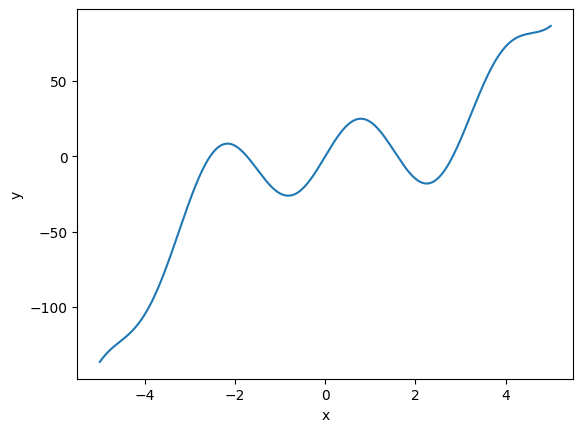

In [1]:
##################################################
## ground-truth model
##################################################

def goalFun(x):
    return(x**3 - x**2 + 25 * np.sin(2*x))

# create linear sequence (x) and apply goalFun (y)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)

# plot the function
d = pd.DataFrame({'x' : x, 'y' : y})
sns.lineplot(data = d, x = 'x', y = 'y')
plt.show()

The training data consists of 100 pairs of  $(x,y)$ values.
Each pair is generated by first sampling an $x$ value from a uniform distribution.
For each sampled $x$, we compute the value of the target function $f(x)$ and add Gaussian noise to it.



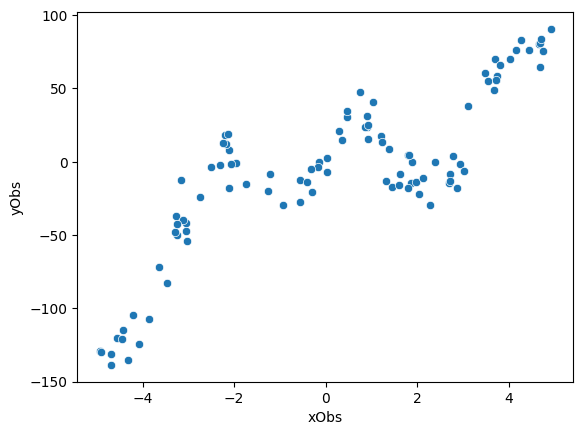

In [1]:
##################################################
## generate training data (with noise)
##################################################

nObs = 100 # number of observations

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=10)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

## Defining the MLP using PyTorch&rsquo;s built-in modules



As before (sheet 4.1), our model maps a single scalar $x$ onto another scalar $y$.
We use a 3-layer MLP, each hidden layer with dimension 10:



In [1]:
##################################################
## network dimension parameters
##################################################

nInput  = 1
nHidden = 10
nOutput = 1

PyTorch defines a special-purpose class called \`nn.Module\` from which pre-defined neural networks or custom-made networks inherit the structure and basic functionality.
Below, we define our feed-forward neural network as a class extending \`nn.Module\`.
Minimally, we have to define two functions for this to work:

1.  the **initialization** function \`\_<sub>init</sub>\_\_\` which defines which variables (parameters) our model has (using \`nn.Linear\` instantiates a linear layer with all the trainable parameters (slopes and intercepts) implicitly)
2.  the **forward pass** which takes the models input as input and computes a single forward pass; (recall the function \`singleForwardPass\` from sheet 4.1; PyTorch automatically batches the computation implicitly).



In [1]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- explicit version --
##################################################

class MLPexplicit(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super(MLPexplicit, self).__init__()
        self.nInput  = nInput
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.linear1 = nn.Linear(self.nInput, self.nHidden)
        self.linear2 = nn.Linear(self.nHidden, self.nHidden)
        self.linear3 = nn.Linear(self.nHidden, self.nHidden)
        self.linear4 = nn.Linear(self.nHidden, self.nOutput)
        self.ReLU    = nn.ReLU()

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        h2 = self.ReLU(self.linear2(h1))
        h3 = self.ReLU(self.linear3(h2))
        output = self.linear4(h3)
        return(output)

mlpExplicit = MLPexplicit(nInput, nHidden, nOutput)

We can access the current parameter values of this model instance like so:



In [1]:
for p in mlpExplicit.parameters():
    print(p.detach().numpy().round(4))

#+begin_example
[[ 0.6566]
 [-0.2715]
 [ 0.1   ]
 [-0.6088]
 [-0.3145]
 [ 0.0786]
 [ 0.1589]
 [ 0.9464]
 [ 0.464 ]
 [-0.2565]]
[-0.8989  0.3264  0.0493 -0.8252  0.4352  0.6026  0.2613  0.0761  0.0919
 -0.1544]
[[ 0.0667  0.2916 -0.1159 -0.0075  0.2165  0.0103  0.0735  0.0703  0.1747
   0.2944]
 [ 0.1093  0.2659 -0.1104  0.0347  0.2785 -0.2571  0.0714 -0.2689  0.2018
   0.25  ]
 [ 0.0317  0.0892  0.0019 -0.0311 -0.0647  0.055   0.0024  0.1575 -0.1316
  -0.0139]
 [-0.2618  0.095  -0.0069  0.0148  0.1265 -0.2153  0.1384  0.0256  0.2671
  -0.2913]
 [-0.2024  0.124   0.2512 -0.2969 -0.1139  0.1137  0.1185  0.0499 -0.1809
   0.0229]
 [-0.0203 -0.0651 -0.3054 -0.0772 -0.1764 -0.1131 -0.0679 -0.2239 -0.0613
   0.2607]
 [-0.1001  0.1714 -0.1914  0.0705  0.1523  0.0133  0.0384  0.1135 -0.2007
   0.1746]
 [ 0.0654 -0.1662  0.1564 -0.2365 -0.1137  0.0126  0.1346 -0.0154 -0.1013
  -0.3141]
 [-0.26   -0.2271  0.3118  0.1093 -0.0489  0.1298 -0.101   0.0144 -0.1015
   0.2442]
 [-0.1782  0.1336 -0.1322

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.2.1: Inspect the model&rsquo;s parameters and their initial values</span></strong>
>
> 0. [Just for yourself.] Make sure that you understand what these parameters are by mapping these onto the parameters of the custom-made model from sheet 4.1. (Hint: the order of the presentation in this print-out is the order in which the components occur in the computation of the forward pass.)
>
> 1. Guess how the weights of the slope matrices are initialized (roughly). Same for the intercept vectors.

There are several ways in which we can define our ANNs in PyTorch.
Here is another, more condensed representation which uses the \`nn.Sequantial\` function to neatly chain components, thus defining the model parameters and the forward pass in one swoop.



In [1]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- condensed version --
##################################################

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

mlpCondensed = MLPcondensed(nInput, nHidden, nOutput)

Here you can select which one to use.



In [1]:
# which model to use from here onwards
# model = mlpExplicit
model = mlpCondensed

## Preparing the training data



Code for processing data samples can get messy and hard to maintain;
we ideally want our dataset code to be decoupled from our model
training code for better readability and modularity.
PyTorch provides two data primitives: torch.utils.data.DataLoader
and torch.utils.data.Dataset that allow you to use pre-loaded
datasets as well as your own data. Dataset stores the samples and
their corresponding labels, and DataLoader wraps an iterable around the
Dataset to enable easy access to the samples.



In [1]:
##################################################
## representing train data as a Dataset object
##################################################

class nonLinearRegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

d = nonLinearRegressionData(xObs, yObs)

train_dataloader = DataLoader(d, batch_size=100, shuffle=True)

# for i, data in enumerate(train_dataloader, 0):
#     input, target = data
#     print(input, target)
#     output = mlp(torch.reshape(input, (len(input), 1))).squeeze()
#     print(i, input, target, output)

## Training the model



#+begin_example
Loss after epoch  2500: 2294.125
Loss after epoch  5000: 967.532
Loss after epoch  7500: 891.338
Loss after epoch 10000: 830.446
Loss after epoch 12500: 711.378
Loss after epoch 15000: 448.622
Loss after epoch 17500: 259.301
Loss after epoch 20000: 167.837
Loss after epoch 22500: 129.881
Loss after epoch 25000: 118.501
Loss after epoch 27500: 109.078
Loss after epoch 30000: 101.994
Loss after epoch 32500: 96.188
Loss after epoch 35000: 91.415
Loss after epoch 37500: 88.853
Loss after epoch 40000: 86.167
Loss after epoch 42500: 83.446
Loss after epoch 45000: 80.866
Loss after epoch 47500: 78.467
Loss after epoch 50000: 76.754
Training process has finished.
#+end_example

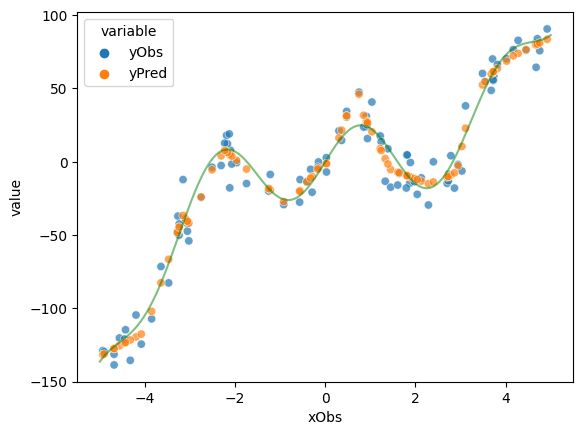

In [1]:
##################################################
## training the model
##################################################

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
nTrainSteps = 50000

model.train() # TODO: explain this

# Run the training loop
for epoch in range(0, nTrainSteps):

  # Set current loss value
  current_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(train_dataloader, 0):

    # Get inputs
    inputs, targets = data

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass (make sure to supply the input in the right way)
    outputs = model(torch.reshape(inputs, (len(inputs), 1))).squeeze()

    # Compute loss
    loss = loss_function(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Print statistics
    current_loss += loss.item()
    if (epoch + 1) % 2500 == 0:
        print('Loss after epoch %5d: %.3f' %
              (epoch + 1, current_loss))
        current_loss = 0.0

# Process is complete.
print('Training process has finished.')

model.eval()  # TODO: explain this

yPred = np.array([model.forward(torch.tensor([o])).detach().numpy() for o in xObs]).flatten()

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()